<a href="https://colab.research.google.com/github/erYash15/StackOverflow-Tag-Prediction/blob/master/facebook_recruiting_iii_keyword_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting the google drive to Google colab Notebook

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**Step 1** — Get the API key from your account
Visit www.kaggle.com ⇨ login ⇨ My Account ⇨ Create New API Token
The “kaggle.json” file will be auto downloaded.

**Step 2** — Upload the kaggle.json file
Use these code snippets in Google Colab for the task:

In [0]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eryash15","key":"4d3c754d226d7fba028ded4615217df0"}'}

The below will create the necessary folder path.

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


**Step 3** — Download the required dataset
Simply download the required dataset with the syntax:

In [0]:
!kaggle competitions download -c facebook-recruiting-iii-keyword-extraction -p /content/gdrive/My\ Drive/kaggle

100% 2.18G/2.19G [00:27<00:00, 98.0MB/s]
100% 2.19G/2.19G [00:27<00:00, 84.3MB/s]
100% 4.81M/4.81M [00:00<00:00, 41.5MB/s]

 99% 718M/725M [00:09<00:00, 86.0MB/s]
100% 725M/725M [00:09<00:00, 83.1MB/s]


**Step 4** — Unzip

*For dataset with multiple zip files like the example, I tend to change directory to the designated folder and unzip them one by one.*

!unzip -q file[.zip] -d [exdir]

-q suppress the printing of the file names being extracted

-d [exdir] optional directory to which to extract files *italicized text*

In [0]:
import os
os.chdir('/content/gdrive/My Drive/kaggle')  #change dir
!unzip Train.zip  #unzip data
!unzip Test.zip  #unzip data
!unzip SampleSubmission.csv.zip

Archive:  Train.zip
  inflating: Train.csv               
Archive:  Test.zip
  inflating: Test.csv                
Archive:  SampleSubmission.csv.zip
  inflating: SampleSubmission.csv    


### **Import Libraries**

In [0]:
%matplotlib inline

# Basic System Libraries
import os
import datetime
import csv
import math
from tqdm import tqdm
import pickle


# Data Manipulation Libraries
import pandas as pd
import numpy as np


# Data Ploting Libraries
import matplotlib.pyplot as plt
import seaborn as sns



# Natural Language Processing Libraries
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer


# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score






## **Data Cleaning** - Stage 1

In [0]:
train_df = pd.read_csv('/content/gdrive/My Drive/kaggle/Train.csv')

In [0]:
print("Length of Raw input Train data", len(train_df))

Length of Raw input Train data 6034195


In [0]:
#Null Data Field
for c in train_df.columns:   
    print("Number of Null Cells in ---",c,"----are ",train_df[c].isnull().sum())

Number of Null Cells in --- Id ----are  0
Number of Null Cells in --- Title ----are  0
Number of Null Cells in --- Body ----are  0
Number of Null Cells in --- Tags ----are  8


In [0]:
#Remove Duplicates and field with Null Values
train_df.drop_duplicates(subset = ['Title','Body','Tags'], keep = 'first', inplace = True)
train_df.dropna(axis = 'index', how =  'any', inplace = True)

In [0]:
print("Length of Raw input Train data", len(train_df))

Length of Raw input Train data 4206307


Add tag_count coloumn in train_df

In [0]:
tags_count = []
for tags in train_df.Tags:
    tags_count.append(len(tags.split(" ")))
train_df['Tags_count'] = tags_count
del tags_count 

In [0]:
train_df.head()

,Id,Title,Body,Tags,Tags_count
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents,3


Saving the train_df file in Google Drive.

In [0]:
train_df.to_csv("/content/gdrive/My Drive/kaggle/train_df.csv")
print("train_df saved to google drive.")

train_df saved to google drive.


Reading the train_df file from Google Drive.

In [0]:
train_df = pd.read_csv("/content/gdrive/My Drive/kaggle/train_df.csv")

## **Analysis of Tags**

In [0]:
#making spare matrix of tags
cv = CountVectorizer(tokenizer = lambda x: x.split()) 
# if we don't use tokenizer only numeric and albhabet will ignore .-, etc.
# and igonre the word with 1 letter.
tag_mtx = cv.fit_transform(train_df['Tags'])

In [0]:
print("Number of data points :", tag_mtx.shape[0])#rows
print("Number of unique tags :", tag_mtx.shape[1])#columns

Number of data points : 4206307
Number of unique tags : 42048


freq_dict contains all the tags and its frequency.

In [0]:
all_unique_tags = cv.get_feature_names()
freq = tag_mtx.sum(axis = 0).A1
#.A1 convert everyting to 1-D
freq_dict = dict(zip(all_unique_tags,freq))

Saving freq_dict in Google Drive and then converting it to pandas dataframe because for converting dictionary directly to pandas dataframe we have to convert values in list form and to avoid we first create .csv file. 

In [0]:
#Saving this dictionary to csv files.
with open('/content/gdrive/My Drive/kaggle/tag_freq_dict.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in freq_dict.items():
        writer.writerow([key, value])

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


Reading only the tag_df file

In [0]:
tag_df = pd.read_csv('/content/gdrive/My Drive/kaggle/tag_freq_dict.csv', names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


Sorting the tag_df in the decending order

In [0]:
tag_df.sort_values(['Counts'], inplace = True, ascending = False)

In [0]:
tag_df.head(10)

,Tags,Counts
4337,c#,331505
18069,java,299414
27249,php,284103
18157,javascript,265423
1234,android,235436
18608,jquery,221533
4346,c++,143936
29101,python,134137
17643,iphone,128681
2215,asp.net,125651


### Tag **Plots**

Plot the Distribution of Frequency of Tags

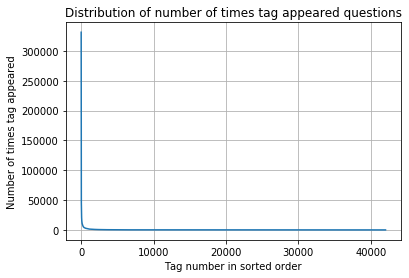

In [0]:
plt.plot(tag_df['Counts'].values)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number in sorted order")
plt.ylabel("Number of times tag appeared")
plt.show()

In [0]:
print("Tags that appered more than 10000 times: ", len( tag_df.loc[tag_df['Counts'] > 10000]))
print("Tags that appered less than 100 times: ", len( tag_df.loc[tag_df['Counts'] < 100])

Tags that appered more than 10000 times:  153
Tags that appered less than 100 times:  33758


*Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.*



Describtion of Tags Count

In [0]:
train_df.Tags_count.describe()

count    4.206307e+06
mean     2.899443e+00
std      1.211915e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Tags_count, dtype: float64

In [0]:
train_df.Tags_count.value_counts()

3    1206157
2    1111706
4     814996
1     568290
5     505158
Name: Tags_count, dtype: int64

**Making Fancy word cloud which shows larger the font size greater the frequency.**

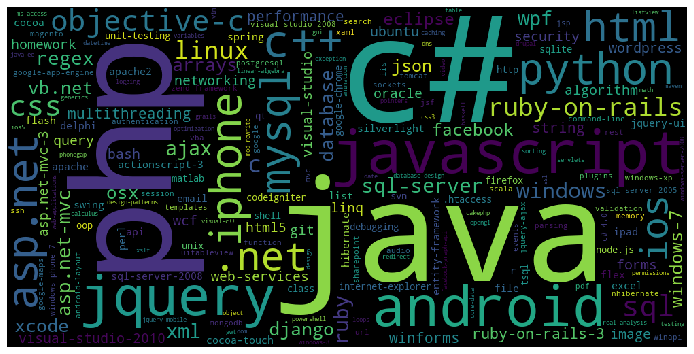

Time taken to run this cell : 0:00:01.941666


In [0]:
#plot word cloud
start = datetime.datetime.now()
# Lets first convert tag_df to 'list of tuples'
list_of_tuples = []
for t in tag_df.values:
  list_of_tuples.append(tuple(t))
#Initializing  WordCloud
wordcloud = WordCloud(background_color = 'black', width=1000, height=500).generate_from_frequencies(dict(list_of_tuples))
fig = plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.tight_layout(pad=1)
fig.savefig("/content/gdrive/My Drive/kaggle/tag.png")
plt.show()
print("Time taken to run this cell :", datetime.datetime.now() - start)

# **Data Cleaning** - Stage 2

pattern = eeeAiiZuuuuAoooZeeee

The patterns yield the following matches:

    A.*Z yields 1 match: AiiZuuuuAoooZ (This backiters and finds the last Z)

    A.*?Z yields 2 matches: AiiZ and AoooZ (This frontiters and find the maximum matches)

In [0]:
#This function remove the html tags from the string
def striphtml(data):
  cleanr = re.compile(r'(<.*?>)')
  cleantext = re.sub(cleanr, ' ', data)
  return cleantext

def alpha(data):
  pattern_not_alphabet = re.compile(r'[^A-Za-z]+')
  pattern_not_alphabet_text = re.sub(pattern_not_alphabet, ' ', data)
  return pattern_not_alphabet_text


Downloaded all **nltk** resource by nltk.download() but, as I found out, it takes **~2.5GB**. To use only **nltk.tokenize.word_tokenize** just download ** untill it gives error**.

In [0]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Program below is capable for incomplete runs! because Google colab kernel dies after every 90 minutes of idel time, weak connection or memory overload. So that file can continue the file rather than restart the process from the work was left unfinished.

### Training Data

In [0]:
stop_words = set(stopwords.words('english'))
stemmer  = SnowballStemmer('english')
pattern_code = re.compile(r'<code>(.*?)</code>')

In [0]:
with open('/content/gdrive/My Drive/kaggle/processed_training_data.csv', 'a+') as csv_file:
  writer = csv.writer(csv_file)
  
  #Counting lines and re-initiating the process if fails.
  num_lines = sum(1 for line in open('/content/gdrive/My Drive/kaggle/processed_training_data.csv'))
  if(num_lines == 0):
    writer.writerow(['Question','Tags'])
    num_lines = 1
  print("Lines already processed : ", num_lines-1)
  
  for i in tqdm(range(num_lines-1, 4206307)):
    
    # Raw text
    Body_text = str(train_df['Body'][i].encode('utf-8'))
    Title_text = str(train_df['Title'][i].encode('utf-8'))

    # strip html and non-aplha
    Body_striphtml = striphtml( Body_text ) 
    Body_striphtml_alpha = alpha(Body_striphtml)
    Title_alpha = alpha(Title_text)

    #removing stopwords and stem the text except the 'c' and 'r' because it is programming language.
    Body_words = word_tokenize(Body_striphtml_alpha.lower())
    Body_striphtml_stemmer = ' '.join(str(stemmer.stem(j)) for j in Body_words if j not in stop_words and (len(j)!=1 or j=='c'))   
    Title_words = word_tokenize( Title_alpha )     
    Title_stemmer = ' '.join(str(stemmer.stem(j)) for j in Title_words if j not in stop_words and (len(j)!=1 or j=='c' or j=='r'))
    
    #We here 3 times the Title to give more weight.
    processed_list = []
    processed_list.extend([Title_stemmer, Title_stemmer, Title_stemmer, Body_striphtml_stemmer])
    
    #This sub-section are used to extract the codes in the text.
    codes = pattern_code.findall( Body_text ) 
    for code in codes:
      #processing code
      code_Text = alpha(code)
      code_words = word_tokenize( code_Text )     
      code_stemmer = ' '.join(str(stemmer.stem(j)) for j in code_words if j not in stop_words and (len(j)!=1 or j=='c'))
      processed_list.append(code_stemmer)
    
    #converting list to string
    processed_string = " ".join(processed_list)
    writer.writerow([processed_string,train_df['Tags'][i]])
print("Training File Is Processed Completely and saved as processed_training_data.csv")

0it [00:00, ?it/s]

Lines already processed :  4206307
Training File Is Processed Completely and saved as processed_training_data.csv


##Test Data

In [0]:
test_df = pd.read_csv('/content/gdrive/My Drive/kaggle/Test.csv')
test_size = len(test_df['Id'])

with open('/content/gdrive/My Drive/kaggle/processed_testing_data.csv', 'a+') as csv_file:
  writer = csv.writer(csv_file)
  
  #Counting lines and re-initiating the process if fails.
  num_lines = sum(1 for line in open('/content/gdrive/My Drive/kaggle/processed_testing_data.csv'))
  if(num_lines == 0):
    writer.writerow(['Question'])
    num_lines = 1
  print("Lines already processed : ", num_lines-1)
  
  for i in tqdm(range(num_lines-1, test_size)):
    
    # Raw text
    Body_text = str(test_df['Body'][i].encode('utf-8'))
    Title_text = str(test_df['Title'][i].encode('utf-8'))

    # strip html and non-aplha
    Body_striphtml = striphtml( Body_text ) 
    Body_striphtml_alpha = alpha(Body_striphtml)
    Title_alpha = alpha(Title_text)

    #removing stopwords and stem the text except the 'c' and 'r' because it is programming language.
    Body_words = word_tokenize(Body_striphtml_alpha.lower())
    Body_striphtml_stemmer = ' '.join(str(stemmer.stem(j)) for j in Body_words if j not in stop_words and (len(j)!=1 or j=='c'))   
    Title_words = word_tokenize( Title_alpha )     
    Title_stemmer = ' '.join(str(stemmer.stem(j)) for j in Title_words if j not in stop_words and (len(j)!=1 or j=='c' or j=='r'))
    
    #We here 3 times the Title to give more weight.
    processed_list = []
    processed_list.extend([Title_stemmer, Title_stemmer, Title_stemmer, Body_striphtml_stemmer])
    
    #This sub-section are used to extract the codes in the text.
    codes = pattern_code.findall( Body_text ) 
    for code in codes:
      #processing code
      code_Text = alpha(code)
      code_words = word_tokenize( code_Text )     
      code_stemmer = ' '.join(str(stemmer.stem(j)) for j in code_words if j not in stop_words and (len(j)!=1 or j=='c'))
      processed_list.append(code_stemmer)
    
    #converting list to string
    processed_string = " ".join(processed_list)
    writer.writerow([processed_string])
print("Testing File Is Processed Completely and saved as processed_testing_data.csv")

  0%|          | 38/2013337 [00:00<1:41:40, 330.02it/s]

Lines already processed :  0


100%|██████████| 2013337/2013337 [1:51:56<00:00, 299.75it/s]

Testing File Is Processed Completely and saved as processed_testing_data.csv


# Machine Learning

## Spliting the training Data

Spiliting the Training Data into 80:20 for training the model.

In [0]:
processed_training_data = pd.read_csv('/content/gdrive/My Drive/kaggle/processed_training_data.csv')

X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(processed_training_data['Question']), pd.DataFrame(processed_training_data['Tags']), test_size = 0.2, random_state = 42)
X_train.to_csv('/content/gdrive/My Drive/kaggle/X_train.csv')
X_test.to_csv('/content/gdrive/My Drive/kaggle/X_test.csv')
y_train.to_csv('/content/gdrive/My Drive/kaggle/y_train.csv')
y_test.to_csv('/content/gdrive/My Drive/kaggle/y_test.csv')

Reading the splited files.

In [0]:
#X_train_df = pd.read_csv('/content/gdrive/My Drive/kaggle/X_train.csv')
#X_test_df = pd.read_csv('/content/gdrive/My Drive/kaggle/X_test.csv')
#y_train_df = pd.read_csv('/content/gdrive/My Drive/kaggle/y_train.csv')
y_test_df = pd.read_csv('/content/gdrive/My Drive/kaggle/y_test.csv')

## Tags Reduction

Redction of Tags due to limited computation Power.
Reduction of Tags will be done based on the partial coverage of the question . If a question can be given any one tag then it will be considered covered.

In [0]:
tag_df = pd.read_csv('/content/gdrive/My Drive/kaggle/tag_freq_dict.csv', names=['Tags', 'Counts'])
tag_df.sort_values(['Counts'], inplace = True, ascending = False)

#Saving this sorted dictionary to csv files.
tag_df.to_csv('/content/gdrive/My Drive/kaggle/tag_freq_dict_sorted.csv')

In [0]:
#making spare matrix of tags
cv = CountVectorizer(tokenizer = lambda x: x.split()) 
# if we don't use tokenizer only numeric and albhabet will be chossen and ignore .-, etc.
# and igonre the word with 1 letter.
tag_mtx = cv.fit_transform(y_train_df['Tags'])

all_unique_tags = cv.get_feature_names()
freq = tag_mtx.sum(axis = 0).A1
#.A1 convert everyting to 1-D
freq_dict = dict(zip(all_unique_tags,freq))

In [0]:
start = datetime.datetime.now()

#Read the tags sorted files.
tag_df = pd.read_csv('/content/gdrive/My Drive/kaggle/tag_freq_dict_sorted.csv')

#lets see first 2000 tags.
Questions_Coverage = [ 0 for i in range(3365045)]
Selected_Tags = []
Selected_Tags_Percentage = []
for t in (range(2000)):
  if(tag_df['Tags'][t] in all_unique_tags):
    ques_lst =  list(tag_mtx.tocsr()[:,all_unique_tags.index(tag_df['Tags'][t])].todense().A1)
    for i in range(3365045):
      Questions_Coverage[i] = Questions_Coverage[i] or ques_lst[i]
    Selected_Tags.append(tag_df['Tags'][t])
    Selected_Tags_Percentage.append(Questions_Coverage.count(1) / 3365045 * 100)
    if(len(Selected_Tags)%10 0==0):
      print("Length of Selected Tags ", len(Selected_Tags), " covers the ", Selected_Tags_Percentage[-1] , " percent of questions.")
print("Time of completion of subsection", datetime.datetime.now() - start)

Length of Selected Tags  100  covers the  76.51740169893716  percent of questions.
Length of Selected Tags  200  covers the  83.17327108552783  percent of questions.
Length of Selected Tags  300  covers the  86.26071865309379  percent of questions.
Length of Selected Tags  400  covers the  88.41281468747074  percent of questions.
Length of Selected Tags  500  covers the  90.06149992050626  percent of questions.
Length of Selected Tags  600  covers the  91.23524351085945  percent of questions.
Length of Selected Tags  700  covers the  92.14355231505077  percent of questions.
Length of Selected Tags  800  covers the  92.89941144917823  percent of questions.
Length of Selected Tags  900  covers the  93.69788516944053  percent of questions.
Length of Selected Tags  1000  covers the  94.17193529358448  percent of questions.
Length of Selected Tags  1100  covers the  94.5581708416975  percent of questions.
Length of Selected Tags  1200  covers the  94.84283271100387  percent of questions.
Le

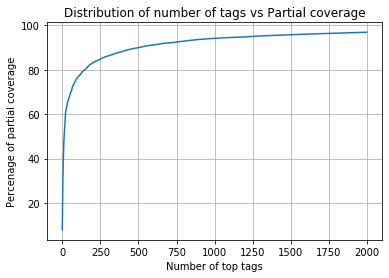

In [0]:
plt.plot(Selected_Tags_Percentage)
plt.title("Distribution of number of tags vs Partial coverage")
plt.grid()
plt.xlabel("Number of top tags")
plt.ylabel("Percenage of partial coverage")
plt.show()

In [0]:
with open("/content/gdrive/My Drive/kaggle/Selected_Tags.txt","wb") as fp: #pickling
  pickle.dump(Selected_Tags,fp)

In [0]:
with open("/content/gdrive/My Drive/kaggle/Selected_Tags.txt", "rb") as fp:   # Unpickling
  Selected_Tags = pickle.load(fp)

## Removing no coverage




With the above knowledge we can say 500 tags are sufficient to cover more than 90 percentage of data. 

Here 2 steps are foloowed in order.

1.   Remove all tags not in top 500 tags.
2.   Remove the questions with no tags or no coverage.

In [0]:
#for training data
start = datetime.datetime.now()
set_selected_tags_500 = set(Selected_Tags[0:500])

remove_index = []
new_tags = []
no_of_questions = len(y_train_df['Tags'])

with open('/content/gdrive/My Drive/kaggle/y_train_500_df.csv', 'a+') as csv_file:
  writer = csv.writer(csv_file)
  writer.writerow(['Tags'])
  for i in tqdm(range(no_of_questions)):
    tags_words = y_train_df['Tags'][i].split(" ")
    temp_tags = list(set(tags_words).intersection(set_selected_tags_500))
    if(len(temp_tags) == 0):
      remove_index.append(i)
    else:  
      writer.writerow([" ".join(temp_tags)])
print("Time to run this Sub-Section", datetime.datetime.now()-start)

100%|██████████| 3365045/3365045 [01:35<00:00, 35244.21it/s]

Time to run this Sub-Section 0:01:35.501290


In [0]:
#for testing data
start = datetime.datetime.now()
set_selected_tags_500 = set(Selected_Tags[0:500])

new_tags = []
no_of_questions = len(y_test_df['Tags'])

with open('/content/gdrive/My Drive/kaggle/y_test_500_df.csv', 'a+') as csv_file:
  writer = csv.writer(csv_file)
  writer.writerow(['Tags'])
  for i in tqdm(range(no_of_questions)):
    tags_words = y_test_df['Tags'][i].split(" ")
    temp_tags = list(set(tags_words).intersection(set_selected_tags_500))
    writer.writerow([" ".join(temp_tags)])
print("Time to run this Sub-Section", datetime.datetime.now()-start)

100%|██████████| 841262/841262 [00:14<00:00, 57796.71it/s]

Time to run this Sub-Section 0:00:14.565786


In [0]:
with open("/content/gdrive/My Drive/kaggle/remove_index.txt","wb") as fp: #pickling
  pickle.dump(remove_index,fp)

with open("/content/gdrive/My Drive/kaggle/remove_index.txt", "rb") as fp:   # Unpickling
  remove_index = pickle.load(fp)

X_train_500_df = X_train_df.drop(remove_index)
X_train_500_df.to_csv('/content/gdrive/My Drive/kaggle/X_train_500_df.csv')

In [0]:
X_train_500_df = pd.read_csv('/content/gdrive/My Drive/kaggle/X_train_500_df.csv')
X_test_500_df = pd.read_csv('/content/gdrive/My Drive/kaggle/X_test.csv')

In [0]:
X_train_500_df

,Unnamed: 0,Unnamed: 0.1,Question
0,0,1040695,linux store arp cach entri use wrong interfac ...
1,1,1403212,replic linkedin databus sqlserver replic linke...
2,2,1197568,getinst infer usag tri specifi type argument e...
3,3,206301,how add new key valu pair specif associ key as...
4,4,1279280,percentcomplet achiev return decim valu percen...
...,...,...,...
3030605,3365039,1239911,how append function draggabl item replacewith ...
3030606,3365041,1136074,jqueri duplic span append use fadeout jqueri d...
3030607,3365042,1570006,white hat test white hat test white hat test g...
3030608,3365043,2234489,how tell link exe use wmain entri point lnk un...


In [0]:
X_test_500_df

,Unnamed: 0,Question
0,4168912,is safe assign nullptr function pointer variab...
1,993923,android javascriptinterfac problem android jav...
2,89794,vertic slider fill bar chang colour depend lar...
3,452746,can vs vspackag project instal vs can vs vspac...
4,2322953,shortcom declar program shortcom declar progra...
...,...,...
841257,3022021,how disabl open window explor scan how disabl ...
841258,2228071,php class problem php class problem php class ...
841259,285336,selenium use ff profil trust ssl certif seleni...
841260,2997759,powershel some command run invok command power...


## Featurizing data with TF-IDF vectorizer

Featurizing test data is invalid though but just to check I did for train and test data.

In [0]:
start = datetime.datetime.now()
#smooth_idf=True by default so smoothing is done by defult.
#norm is l2 by default.
#subliner is used False by default.
vectorizer = TfidfVectorizer(min_df = 0.0001, 
                             max_features = 100000, 
                             tokenizer = lambda x: x.split(),
                             ngram_range = (1,2))
x_train_tfidf = vectorizer.fit_transform( X_train_500_df['Question'])  # fit_transform - create vocablary and transform the data.
X_test_tfidf = vectorizer.transform( X_test_500_df['Question'] )  # transform - fit in the available vocablary.

print("Time to run this Subsection ", datetime.datetime.now() - start)

Time to run this Subsection  0:19:09.357316


In [0]:
with open("/content/gdrive/My Drive/kaggle/X_train_tfidf.pkl","wb") as fp: #pickling
  pickle.dump(x_train_tfidf,fp)
with open("/content/gdrive/My Drive/kaggle/X_test_tfidf.pkl","wb") as fp: #pickling
  pickle.dump(X_test_tfidf,fp)

In [0]:
print("Dimensions of train data X:",x_train_tfidf.shape)
print("Dimensions of test data X:",X_test_tfidf.shape)

Dimensions of train data X: (3030610, 100000)
Dimensions of test data X: (841262, 100000)


## Featurizing Labels

In [0]:
y_train_500_df = pd.read_csv('/content/gdrive/My Drive/kaggle/y_train_500_df.csv')
y_test_500_df = pd.read_csv('/content/gdrive/My Drive/kaggle/y_test_500_df.csv')
y_test_500_df.replace(np.nan, '', regex = True, inplace = True)

In [0]:
type(x_train_tfidf)

scipy.sparse.csr.csr_matrix

In [0]:
#making spare matrix of tags
cv = CountVectorizer(tokenizer = lambda x: x.split(), binary='true') 
y_train_500_df_mtx = cv.fit_transform(y_train_500_df['Tags'])
y_test_500_df_mtx = cv.transform(y_test_500_df['Tags'])

In [0]:
type(y_train_500_df_mtx)

scipy.sparse.csr.csr_matrix

In [0]:
print("Dimensions of train data Y :", y_train_500_df_mtx.shape)
print("Dimensions of test data Y:", y_test_500_df_mtx.shape)

Dimensions of train data Y : (3030610, 500)
Dimensions of test data Y: (841262, 500)


In [0]:
with open("/content/gdrive/My Drive/kaggle/y_train_500_df_mtx.pkl","wb") as fp: #pickling
  pickle.dump(y_train_500_df_mtx,fp)
with open("/content/gdrive/My Drive/kaggle/y_test_500_df_mtx.pkl","wb") as fp: #pickling
  pickle.dump(y_test_500_df_mtx,fp)

## OneVsRest Classifier with SGDClassifier using TFIDF

In [0]:
with open("/content/gdrive/My Drive/kaggle/X_train_tfidf.pkl","rb") as fp: #unpickling
  x_train = pickle.load(fp)
with open("/content/gdrive/My Drive/kaggle/X_test_tfidf.pkl","rb") as fp: #unpickling
  x_test = pickle.load(fp)
with open("/content/gdrive/My Drive/kaggle/y_train_500_df_mtx.pkl","rb") as fp: #unpickling
  y_train = pickle.load(fp)
with open("/content/gdrive/My Drive/kaggle/y_test_500_df_mtx.pkl","rb") as fp: #unpickling
  y_test = pickle.load(fp)

Due to computation limitation we train this model for 1,00,000 training points and 20,000 testing points.

In [25]:
start = datetime.datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log',
                                               alpha=0.00001,
                                               penalty='l1'), n_jobs=-1)
classifier.fit(x_train[:100000], y_train[:100000])
predictions = classifier.predict (x_test[:20000])
print("Accuracy :",accuracy_score(y_test[:20000], predictions))
print("Hamming loss :",hamming_loss(y_test[:20000],predictions))
print("precision score :",precision_score(y_test[:20000], predictions, average='micro'))
print("Recall Score :", recall_score(y_test[:20000], predictions, average='micro'))
print("Time taken to run this cell :", datetime.datetime.now() - start)

Accuracy : 0.22335
Hamming loss : 0.0028816
precision score : 0.6967819091106763
Recall Score : 0.35550255158642113
Time taken to run this cell : 0:03:07.748123


In [0]:
start = datetime.datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log',
                                               alpha=0.00001,
                                               penalty='l1'), n_jobs=-1)
classifier.fit(x_train, y_train)
predictions = classifier.predict (x_test)
print("Accuracy :",accuracy_score(y_test, predictions))
print("Hamming loss :",hamming_loss(y_test,predictions))
print("precision score :",precision_score(y_test, predictions, average='micro'))
print("Recall Score :", recall_score(y_test, predictions, average='micro'))
print("Time taken to run this cell :", datetime.datetime.now() - start)

In [20]:
for i in range(100):
  if(predictions.toarray()[i].sum() !=0 ):
    print(predictions.toarray()[i].sum(), y_test.toarray()[i].sum())

1 3
2 1
1 3
1 3
